In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

In [2]:
df_raw = pd.read_excel('/content/sample_data/Sales_Tzs_April_2024_Nov_2025.xlsx')

In [3]:
# Aggregate to weekly
df_weekly = df_raw.set_index('Date').resample('W').sum().reset_index()

print(f"Weekly observations: {len(df_weekly)}")
print(f"Date range: {df_weekly['Date'].min()} to {df_weekly['Date'].max()}")

# 80-20 split
split_index = int(len(df_weekly) * 0.8)
train = df_weekly[:split_index].copy()
test = df_weekly[split_index:].copy()

print(f"\nTraining set: {len(train)} observations")
print(f"Test set: {len(test)} observations")

Weekly observations: 224
Date range: 2021-08-08 00:00:00 to 2025-11-16 00:00:00

Training set: 179 observations
Test set: 45 observations


In [4]:
# Naive forecast: last observation carried forward
naive_forecast = np.full(len(test), train['Sales'].iloc[-1])

# Calculate metrics
naive_mae = mean_absolute_error(test['Sales'], naive_forecast)
naive_rmse = np.sqrt(mean_squared_error(test['Sales'], naive_forecast))
naive_r2 = r2_score(test['Sales'], naive_forecast)
naive_mape = mean_absolute_percentage_error(test['Sales'], naive_forecast) * 100

print("=== Naive Forecast Performance ===")
print(f"MAE: {naive_mae:,.2f}")
print(f"RMSE: {naive_rmse:,.2f}")
print(f"R²: {naive_r2:.4f}")
print(f"MAPE: {naive_mape:.2f}%")


=== Naive Forecast Performance ===
MAE: 1,725,116.64
RMSE: 2,341,335.78
R²: -0.8156
MAPE: 17215760175561615343616.00%


In [10]:
# Fitting SARIMA model

sarima_model = SARIMAX(train['Sales'],
                           order=(0, 1, 2),
                           seasonal_order=(1, 1, 1, 52),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False, maxiter=200)

    # Forecast
sarima_forecast = sarima_fit.forecast(steps=len(test))

    # Calculating metrics
sarima_mae = mean_absolute_error(test['Sales'], sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test['Sales'], sarima_forecast))
sarima_mape = mean_absolute_percentage_error(test['Sales'], sarima_forecast) * 100

print("\n=== SARIMA Performance ===")
print(f"MAE: {sarima_mae:,.2f}")
print(f"RMSE: {sarima_rmse:,.2f}")
print(f"MAPE: {sarima_mape:.2f}%")



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



=== SARIMA Performance ===
MAE: 1,586,689.48
RMSE: 1,976,764.85
MAPE: 75508052568748769411072.00%


In [11]:
# Preparing data for Prophet
train_prophet = train[['Date', 'Sales']].copy()
train_prophet.columns = ['ds', 'y']

# Fitting Prophet model
try:
    prophet_model = Prophet(yearly_seasonality=True,
                           weekly_seasonality=False,
                           daily_seasonality=False)
    prophet_model.fit(train_prophet)

    # Creating future dataframe
    future = pd.DataFrame({'ds': test['Date']})
    prophet_forecast = prophet_model.predict(future)

    # Extracting predictions
    prophet_pred = prophet_forecast['yhat'].values

    # Calculating metrics
    prophet_mae = mean_absolute_error(test['Sales'], prophet_pred)
    prophet_rmse = np.sqrt(mean_squared_error(test['Sales'], prophet_pred))
    prophet_mape = mean_absolute_percentage_error(test['Sales'], prophet_pred) * 100

    print("\n=== Prophet Performance ===")
    print(f"MAE: {prophet_mae:,.2f}")
    print(f"RMSE: {prophet_rmse:,.2f}")
    print(f"MAPE: {prophet_mape:.2f}%")
    prophet_success = True
except Exception as e:
    print(f"\nProphet Error: {e}")
    prophet_pred = None
    prophet_success = False



=== Prophet Performance ===
MAE: 1,222,024.54
RMSE: 1,676,215.50
MAPE: 70347212877678375862272.00%


In [12]:
# Fitting Holt-Winters model
# Using seasonal_periods=52 for weekly data
try:
    hw_model = ExponentialSmoothing(train['Sales'],
                                    seasonal_periods=52,
                                    trend='add',
                                    seasonal='add')
    hw_fit = hw_model.fit()

    # Forecast
    hw_forecast = hw_fit.forecast(steps=len(test))

    # Calculating metrics
    hw_mae = mean_absolute_error(test['Sales'], hw_forecast)
    hw_rmse = np.sqrt(mean_squared_error(test['Sales'], hw_forecast))
    hw_mape = mean_absolute_percentage_error(test['Sales'], hw_forecast) * 100

    print("\n=== Holt-Winters Performance ===")
    print(f"MAE: {hw_mae:,.2f}")
    print(f"RMSE: {hw_rmse:,.2f}")
    print(f"MAPE: {hw_mape:.2f}%")
    hw_success = True
except Exception as e:
    print(f"\nHolt-Winters Error: {e}")
    hw_forecast = None
    hw_success = False



=== Holt-Winters Performance ===
MAE: 1,415,364.38
RMSE: 1,783,913.95
MAPE: 67958761902918430883840.00%


In [13]:
# Feature engineering for Random Forest
def create_weekly_features(df):
    df = df.copy()
    df['weekofyear'] = df['Date'].dt.isocalendar().week
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['year'] = df['Date'].dt.year

    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Peak season
    df['peak_season'] = ((df['month'] >= 8) & (df['month'] <= 10)).astype(int)

    # Lag features
    df['sales_lag_1'] = df['Sales'].shift(1)
    df['sales_lag_2'] = df['Sales'].shift(2)
    df['sales_lag_4'] = df['Sales'].shift(4)
    df['sales_lag_12'] = df['Sales'].shift(12)

    # Rolling features
    df['sales_rolling_mean_4'] = df['Sales'].rolling(window=4, min_periods=1).mean()
    df['sales_rolling_std_4'] = df['Sales'].rolling(window=4, min_periods=1).std()
    df['sales_rolling_mean_12'] = df['Sales'].rolling(window=12, min_periods=1).mean()

    # Trend
    df['time_index'] = np.arange(len(df))

    return df

# Apply features
df_rf = create_weekly_features(df_weekly)

# Split
train_rf = df_rf[:split_index].dropna().copy()
test_rf = df_rf[split_index:].dropna().copy()

# Define features
feature_cols = ['weekofyear', 'month', 'quarter', 'month_sin', 'month_cos',
                'peak_season', 'time_index',
                'sales_lag_1', 'sales_lag_2', 'sales_lag_4', 'sales_lag_12',
                'sales_rolling_mean_4', 'sales_rolling_std_4', 'sales_rolling_mean_12']

X_train = train_rf[feature_cols]
y_train = train_rf['Sales']
X_test = test_rf[feature_cols]
y_test = test_rf['Sales']

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=400,
                                max_depth=5,
                                min_samples_split=2,
                                random_state=42,
                                n_jobs=-1)
rf_model.fit(X_train, y_train)

# Forecast
rf_forecast = rf_model.predict(X_test)

# Calculate metrics
rf_mae = mean_absolute_error(y_test, rf_forecast)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_forecast))
rf_mape = mean_absolute_percentage_error(y_test, rf_forecast) * 100

print("\n=== Random Forest Performance ===")
print(f"MAE: {rf_mae:,.2f}")
print(f"RMSE: {rf_rmse:,.2f}")
print(f"MAPE: {rf_mape:.2f}%")



=== Random Forest Performance ===
MAE: 1,095,381.59
RMSE: 1,501,009.80
MAPE: 47852725199084495831040.00%


In [16]:
# Creating comparison dataframe
results = pd.DataFrame({
    'Model': ['Naive', 'SARIMA', 'Holt-Winters', 'Prophet', 'Random Forest'],
    'MAE': [naive_mae, sarima_mae if sarima_forecast is not None else np.nan,
            hw_mae if hw_forecast is not None else np.nan,
            prophet_mae if prophet_pred is not None else np.nan, rf_mae],
    'RMSE': [naive_rmse, sarima_rmse if sarima_forecast is not None else np.nan,
             hw_rmse if hw_forecast is not None else np.nan,
             prophet_rmse if prophet_pred is not None else np.nan, rf_rmse],
    'MAPE (%)': [naive_mape, sarima_mape if sarima_forecast is not None else np.nan,
                 hw_mape if hw_forecast is not None else np.nan,
                 prophet_mape if prophet_pred is not None else np.nan, rf_mape]
})

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(results.to_string(index=False))
print("="*70)

# Identifying best model for each metric
print("\nBest Models:")
print(f"Lowest MAE: {results.loc[results['MAE'].idxmin(), 'Model']}")
print(f"Lowest RMSE: {results.loc[results['RMSE'].idxmin(), 'Model']}")
print(f"Lowest MAPE: {results.loc[results['MAPE (%)'].idxmin(), 'Model']}")



MODEL PERFORMANCE COMPARISON
        Model          MAE         RMSE     MAPE (%)
        Naive 1.725117e+06 2.341336e+06 1.721576e+22
       SARIMA 1.586689e+06 1.976765e+06 7.550805e+22
 Holt-Winters 1.415364e+06 1.783914e+06 6.795876e+22
      Prophet 1.222025e+06 1.676215e+06 7.034721e+22
Random Forest 1.095382e+06 1.501010e+06 4.785273e+22

Best Models:
Lowest MAE: Random Forest
Lowest RMSE: Random Forest
Lowest MAPE: Naive


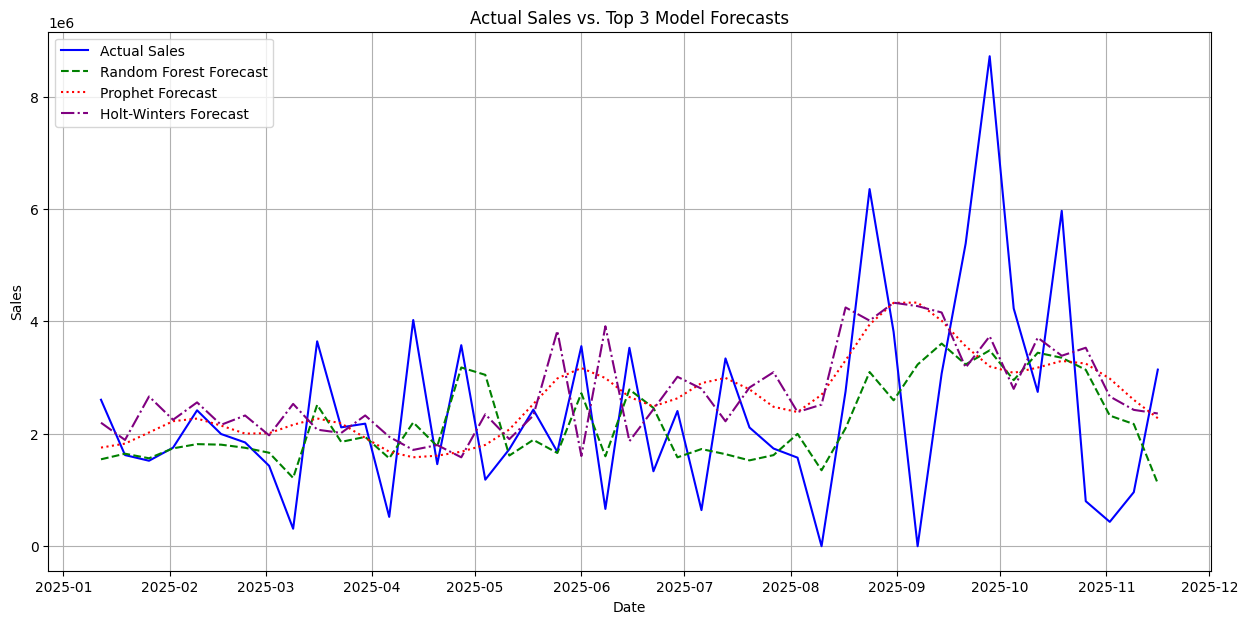

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=plot_df, x='Date', y='Sales', label='Actual Sales', color='blue')
sns.lineplot(data=plot_df, x='Date', y='Random Forest Forecast', label='Random Forest Forecast', color='green', linestyle='--')
sns.lineplot(data=plot_df, x='Date', y='Prophet Forecast', label='Prophet Forecast', color='red', linestyle=':')
sns.lineplot(data=plot_df, x='Date', y='Holt-Winters Forecast', label='Holt-Winters Forecast', color='purple', linestyle='-.')

plt.title('Actual Sales vs. Top 3 Model Forecasts')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
naive_forecast_monthly = np.full(len(test_monthly), train_monthly['Sales'].iloc[-1])

# Calculate metrics
naive_mae_monthly = mean_absolute_error(test_monthly['Sales'], naive_forecast_monthly)
naive_rmse_monthly = np.sqrt(mean_squared_error(test_monthly['Sales'], naive_forecast_monthly))

print("=== Naive Forecast Performance (Monthly) ===")
print(f"MAE: {naive_mae_monthly:,.2f}")
print(f"RMSE: {naive_rmse_monthly:,.2f}")

=== Naive Forecast Performance (Monthly) ===
MAE: 2,848,545.18
RMSE: 4,416,165.97


In [26]:
# Initializing SARIMAX model with monthly seasonality
sarima_monthly_model = SARIMAX(train_monthly['Sales'],
                                   order=(1, 1, 1),
                                   seasonal_order=(1, 1, 1, 12),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)

# Fit the SARIMA model
sarima_monthly_fit = sarima_monthly_model.fit(disp=False, maxiter=200)

# Generate forecasts for the test period
sarima_monthly_forecast = sarima_monthly_fit.forecast(steps=len(test_monthly))

# Calculate MAE and RMSE
sarima_monthly_mae = mean_absolute_error(test_monthly['Sales'], sarima_monthly_forecast)
sarima_monthly_rmse = np.sqrt(mean_squared_error(test_monthly['Sales'], sarima_monthly_forecast))

print("\n=== SARIMA Performance (Monthly) ===")
print(f"MAE: {sarima_monthly_mae:,.2f}")
print(f"RMSE: {sarima_monthly_rmse:,.2f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



=== SARIMA Performance (Monthly) ===
MAE: 3,795,613.25
RMSE: 4,478,452.56


In [27]:
train_prophet_monthly = train_monthly[['Date', 'Sales']].copy()
train_prophet_monthly.columns = ['ds', 'y']

print("Prepared train_monthly data for Prophet (head):")
print(train_prophet_monthly.head())

Prepared train_monthly data for Prophet (head):
          ds            y
0 2021-08-31   7929402.50
1 2021-09-30  10872400.00
2 2021-10-31   7637137.50
3 2021-11-30   6239950.00
4 2021-12-31   6434134.97


In [28]:
# Prophet model with yearly seasonality
prophet_monthly_model = Prophet(yearly_seasonality=True,
                                   weekly_seasonality=False,
                                   daily_seasonality=False)
# Fitting the Prophet model
prophet_monthly_model.fit(train_prophet_monthly)

# Creating future dataframe for predictions
future_monthly = pd.DataFrame({'ds': test_monthly['Date']})
prophet_monthly_forecast_df = prophet_monthly_model.predict(future_monthly)

# Forecasts
prophet_monthly_forecast = prophet_monthly_forecast_df['yhat'].values

# Calculating metrics
prophet_monthly_mae = mean_absolute_error(test_monthly['Sales'], prophet_monthly_forecast)
prophet_monthly_rmse = np.sqrt(mean_squared_error(test_monthly['Sales'], prophet_monthly_forecast))

print("\n=== Prophet Performance (Monthly) ===")
print(f"MAE: {prophet_monthly_mae:,.2f}")
print(f"RMSE: {prophet_monthly_rmse:,.2f}")



=== Prophet Performance (Monthly) ===
MAE: 3,770,590.56
RMSE: 4,215,380.20


In [29]:

# Initialize Holt-Winters model for monthly data
hw_monthly_model = ExponentialSmoothing(train_monthly['Sales'],
                                            seasonal_periods=12,
                                            trend='add',
                                            seasonal='add')
# Fit the Holt-Winters model
hw_monthly_fit = hw_monthly_model.fit()

# Generate forecasts for the test period
hw_monthly_forecast = hw_monthly_fit.forecast(steps=len(test_monthly))

# Calculate metrics
hw_monthly_mae = mean_absolute_error(test_monthly['Sales'], hw_monthly_forecast)
hw_monthly_rmse = np.sqrt(mean_squared_error(test_monthly['Sales'], hw_monthly_forecast))

print("\n=== Holt-Winters Performance (Monthly) ===")
print(f"MAE: {hw_monthly_mae:,.2f}")
print(f"RMSE: {hw_monthly_rmse:,.2f}")



=== Holt-Winters Performance (Monthly) ===
MAE: 1,806,138.36
RMSE: 2,699,227.66


In [30]:
def create_monthly_features(df):
    df = df.copy()
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year

    # Cyclical encoding for month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Peak season (e.g., Q3 for Aug-Oct)
    df['peak_season'] = ((df['month'] >= 8) & (df['month'] <= 10)).astype(int)

    # Lag features
    df['sales_lag_1'] = df['Sales'].shift(1)
    df['sales_lag_2'] = df['Sales'].shift(2)
    df['sales_lag_3'] = df['Sales'].shift(3)
    df['sales_lag_12'] = df['Sales'].shift(12)

    # Rolling features
    df['sales_rolling_mean_3'] = df['Sales'].rolling(window=3, min_periods=1).mean()
    df['sales_rolling_std_3'] = df['Sales'].rolling(window=3, min_periods=1).std()
    df['sales_rolling_mean_6'] = df['Sales'].rolling(window=6, min_periods=1).mean()

    # Trend
    df['time_index'] = np.arange(len(df))

    return df

# Apply the feature engineering function to df_monthly
df_rf_monthly = create_monthly_features(df_monthly)

print("Monthly DataFrame with new features (head):")
print(df_rf_monthly.head())

Monthly DataFrame with new features (head):
        Date        Sales  month  year     month_sin     month_cos  \
0 2021-08-31   7929402.50      8  2021 -8.660254e-01 -5.000000e-01   
1 2021-09-30  10872400.00      9  2021 -1.000000e+00 -1.836970e-16   
2 2021-10-31   7637137.50     10  2021 -8.660254e-01  5.000000e-01   
3 2021-11-30   6239950.00     11  2021 -5.000000e-01  8.660254e-01   
4 2021-12-31   6434134.97     12  2021 -2.449294e-16  1.000000e+00   

   peak_season  sales_lag_1  sales_lag_2  sales_lag_3  sales_lag_12  \
0            1          NaN          NaN          NaN           NaN   
1            1    7929402.5          NaN          NaN           NaN   
2            1   10872400.0    7929402.5          NaN           NaN   
3            0    7637137.5   10872400.0    7929402.5           NaN   
4            0    6239950.0    7637137.5   10872400.0           NaN   

   sales_rolling_mean_3  sales_rolling_std_3  sales_rolling_mean_6  time_index  
0          7.929402e+06    

In [31]:
train_rf_monthly = df_rf_monthly[:split_index_monthly].dropna().copy()
test_rf_monthly = df_rf_monthly[split_index_monthly:].dropna().copy()

feature_cols_monthly = ['month', 'year', 'month_sin', 'month_cos',
                        'peak_season', 'time_index',
                        'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_12',
                        'sales_rolling_mean_3', 'sales_rolling_std_3', 'sales_rolling_mean_6']

X_train_monthly = train_rf_monthly[feature_cols_monthly]
y_train_monthly = train_rf_monthly['Sales']
X_test_monthly = test_rf_monthly[feature_cols_monthly]
y_test_monthly = test_rf_monthly['Sales']

print(f"X_train_monthly shape: {X_train_monthly.shape}")
print(f"y_train_monthly shape: {y_train_monthly.shape}")
print(f"X_test_monthly shape: {X_test_monthly.shape}")
print(f"y_test_monthly shape: {y_test_monthly.shape}")

X_train_monthly shape: (29, 13)
y_train_monthly shape: (29,)
X_test_monthly shape: (11, 13)
y_test_monthly shape: (11,)


In [33]:
try:
    # Instantiate Random Forest Regressor
    rf_monthly_model = RandomForestRegressor(n_estimators=1200,
                                         max_depth=5,
                                         min_samples_split=5,
                                         random_state=42,
                                         n_jobs=-1)
    # Fit the model to the training data
    rf_monthly_model.fit(X_train_monthly, y_train_monthly)

    # Generate forecasts
    rf_monthly_forecast = rf_monthly_model.predict(X_test_monthly)

    # Calculate metrics
    rf_monthly_mae = mean_absolute_error(y_test_monthly, rf_monthly_forecast)
    rf_monthly_rmse = np.sqrt(mean_squared_error(y_test_monthly, rf_monthly_forecast))

    print("\n=== Random Forest Performance (Monthly) ===")
    print(f"MAE: {rf_monthly_mae:,.2f}")
    print(f"RMSE: {rf_monthly_rmse:,.2f}")
except Exception as e:
    print(f"\nRandom Forest Monthly Error: {e}")
    rf_monthly_forecast = None


=== Random Forest Performance (Monthly) ===
MAE: 2,429,149.55
RMSE: 2,983,322.48


In [34]:
monthly_results = pd.DataFrame({
    'Model': ['Naive', 'SARIMA', 'Prophet', 'Holt-Winters', 'Random Forest'],
    'MAE': [naive_mae_monthly, sarima_monthly_mae, prophet_monthly_mae, hw_monthly_mae, rf_monthly_mae],
    'RMSE': [naive_rmse_monthly, sarima_monthly_rmse, prophet_monthly_rmse, hw_monthly_rmse, rf_monthly_rmse]
})

print("\n" + "="*70)
print("MONTHLY MODEL PERFORMANCE COMPARISON")
print("="*70)
print(monthly_results.to_string(index=False))
print("="*70)

print("\nBest Monthly Models:")
print(f"Lowest MAE: {monthly_results.loc[monthly_results['MAE'].idxmin(), 'Model']}")
print(f"Lowest RMSE: {monthly_results.loc[monthly_results['RMSE'].idxmin(), 'Model']}")


MONTHLY MODEL PERFORMANCE COMPARISON
        Model          MAE         RMSE
        Naive 2.848545e+06 4.416166e+06
       SARIMA 3.795613e+06 4.478453e+06
      Prophet 3.770591e+06 4.215380e+06
 Holt-Winters 1.806138e+06 2.699228e+06
Random Forest 2.429150e+06 2.983322e+06

Best Monthly Models:
Lowest MAE: Holt-Winters
Lowest RMSE: Holt-Winters


In [35]:
print("\nTop 3 models by MAE (Monthly Forecasts):")
print(monthly_results.sort_values(by='MAE').head(3).to_string(index=False))

print("\nTop 3 models by RMSE (Monthly Forecasts):")
print(monthly_results.sort_values(by='RMSE').head(3).to_string(index=False))


Top 3 models by MAE (Monthly Forecasts):
        Model          MAE         RMSE
 Holt-Winters 1.806138e+06 2.699228e+06
Random Forest 2.429150e+06 2.983322e+06
        Naive 2.848545e+06 4.416166e+06

Top 3 models by RMSE (Monthly Forecasts):
        Model          MAE         RMSE
 Holt-Winters 1.806138e+06 2.699228e+06
Random Forest 2.429150e+06 2.983322e+06
      Prophet 3.770591e+06 4.215380e+06


In [36]:
plot_df_monthly = test_monthly[['Date', 'Sales']].copy()

# Addding forecasts to the plotting DataFrame
plot_df_monthly['Holt-Winters Forecast'] = hw_monthly_forecast
plot_df_monthly['Random Forest Forecast'] = rf_monthly_forecast
plot_df_monthly['Prophet Forecast'] = prophet_monthly_forecast

print("Plotting DataFrame for monthly forecasts (head):")
print(plot_df_monthly.head())

Plotting DataFrame for monthly forecasts (head):
         Date        Sales  Holt-Winters Forecast  Random Forest Forecast  \
41 2025-01-31   7501100.99           7.926501e+06            7.465789e+06   
42 2025-02-28   7690400.00           8.837928e+06            7.449513e+06   
43 2025-03-31   8774055.00           7.980290e+06            7.499311e+06   
44 2025-04-30  10244477.00           5.212824e+06            7.904287e+06   
45 2025-05-31   9393800.00           9.793523e+06            1.173764e+07   

    Prophet Forecast  
41      1.409768e+07  
42      8.918375e+06  
43      9.224991e+06  
44      5.450317e+06  
45      1.261367e+07  


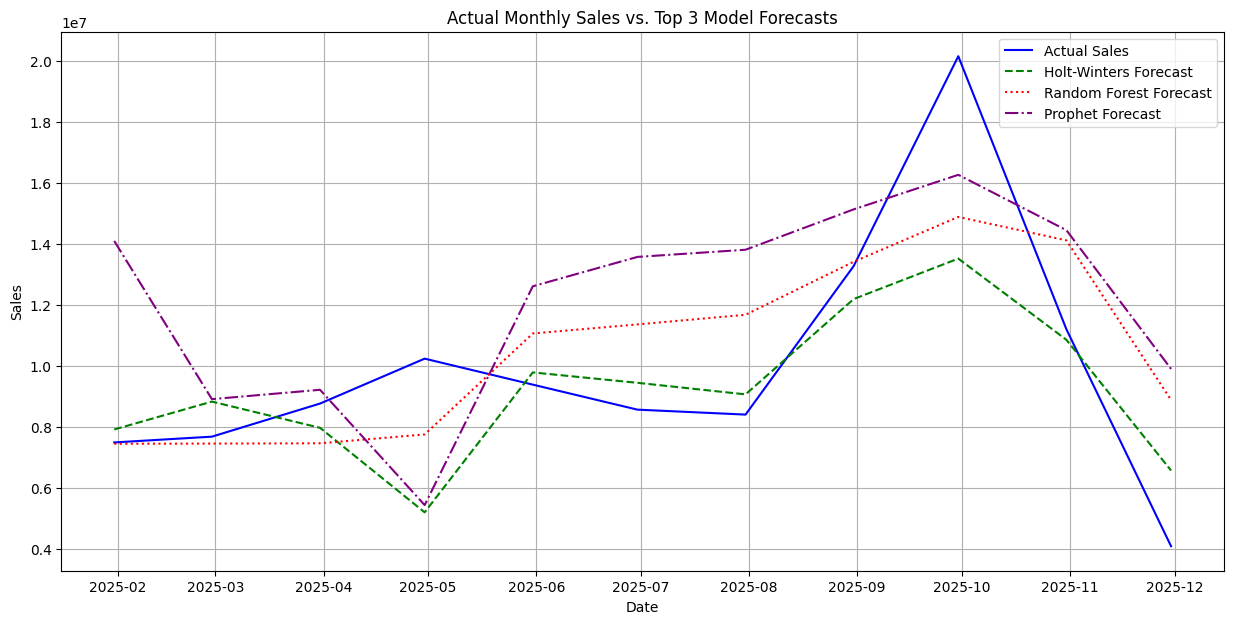

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=plot_df_monthly, x='Date', y='Sales', label='Actual Sales', color='blue')
sns.lineplot(data=plot_df_monthly, x='Date', y='Holt-Winters Forecast', label='Holt-Winters Forecast', color='green', linestyle='--')
sns.lineplot(data=plot_df_monthly, x='Date', y='Random Forest Forecast', label='Random Forest Forecast', color='red', linestyle=':')
sns.lineplot(data=plot_df_monthly, x='Date', y='Prophet Forecast', label='Prophet Forecast', color='purple', linestyle='-.')

plt.title('Actual Monthly Sales vs. Top 3 Model Forecasts')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
df_monthly = df_raw.set_index('Date').resample('M').sum().reset_index()

print(f"Monthly observations: {len(df_monthly)}")
print(f"Date range: {df_monthly['Date'].min()} to {df_monthly['Date'].max()}")
print("\nFirst 5 rows of df_monthly:")
print(df_monthly.head())

Monthly observations: 52
Date range: 2021-08-31 00:00:00 to 2025-11-30 00:00:00

First 5 rows of df_monthly:
        Date        Sales
0 2021-08-31   7929402.50
1 2021-09-30  10872400.00
2 2021-10-31   7637137.50
3 2021-11-30   6239950.00
4 2021-12-31   6434134.97


/tmp/ipython-input-658233854.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_raw.set_index('Date').resample('M').sum().reset_index()


In [20]:
df_monthly = df_raw.set_index('Date').resample('ME').sum().reset_index()

print(f"Monthly observations: {len(df_monthly)}")
print(f"Date range: {df_monthly['Date'].min()} to {df_monthly['Date'].max()}")
print("\nFirst 5 rows of df_monthly:")
print(df_monthly.head())

Monthly observations: 52
Date range: 2021-08-31 00:00:00 to 2025-11-30 00:00:00

First 5 rows of df_monthly:
        Date        Sales
0 2021-08-31   7929402.50
1 2021-09-30  10872400.00
2 2021-10-31   7637137.50
3 2021-11-30   6239950.00
4 2021-12-31   6434134.97


In [21]:
split_index_monthly = int(len(df_monthly) * 0.8)
train_monthly = df_monthly[:split_index_monthly].copy()
test_monthly = df_monthly[split_index_monthly:].copy()

print(f"\nTraining set (monthly): {len(train_monthly)} observations")
print(f"Test set (monthly): {len(test_monthly)} observations")


Training set (monthly): 41 observations
Test set (monthly): 11 observations
